<h2><b><center>Convolutional Neural Network model for Pneumonia detection</center></b></h2>

<h3>1. Import Libraries</h3>


In [ ]:
import cv2 #computer vision lib
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf

from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

#import basemodels
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.densenet import DenseNet121

In [ ]:
#Model results dictionary
model_dict = dict()

<h3>2. Download train dataset</h3>

In [ ]:
#define the path to the dataset

XRay_Directory = '/content/drive/MyDrive/Colab Notebooks/X-ray_dataset/train'

In [ ]:
#show the list of directories

os.listdir(XRay_Directory)

['3', '1', '2', '0']

In [ ]:
#define label names

label_names = {
	0: 'Covid-19',
	1: 'Normal',
	2: 'Viral Pneumonia',
	3: 'Bacterial Pneumonia'
}

<h3>3. Create generators</h3>

In [ ]:
image_generator = ImageDataGenerator(
	rescale = 1./255,
	validation_split = 0.2
)

In [ ]:
train_generator = image_generator.flow_from_directory(
	batch_size = 4,
	directory = XRay_Directory,
	shuffle = True,
	target_size = (256, 256),
	class_mode = 'categorical',
	subset = 'training'
)

Found 428 images belonging to 4 classes.


In [ ]:
val_generator = image_generator.flow_from_directory(
	batch_size = 4,
	directory = XRay_Directory,
	shuffle = True,
	target_size = (256, 256),
	class_mode = "categorical",
	subset = 'validation'
)

Found 104 images belonging to 4 classes.


<h3>4. Earlystopping & ModelCheckpoint</h3>

In [ ]:
earlystopping = EarlyStopping(
	monitor = 'val_loss',
	mode = 'min',
	verbose = 1,
	patience = 20
)

In [ ]:
checkpointer = ModelCheckpoint(
filepath = '/content/drive/MyDrive/Colab Notebooks/weights.keras',
verbose = 1,
save_best_only = True
)

<h3>5. Check training data</h3>

In [ ]:
train_images, train_labels = next(train_generator)

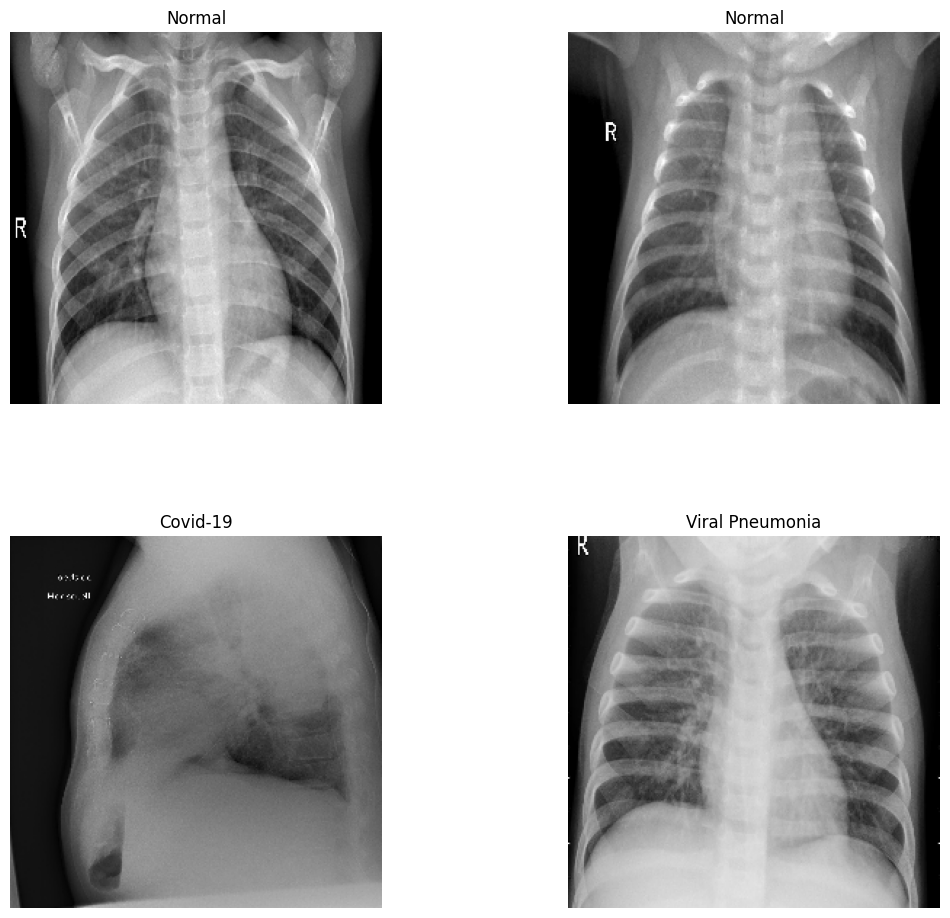

In [ ]:
L = 2
W = 2
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
for i in np.arange(0, L * W):
	axes[i].imshow(train_images[i])
	axes[i].set_title(label_names[np.argmax(train_labels[i])])
	axes[i].axis('off')
plt.subplots_adjust(wspace = 0.5)

<h3> 6. Train models </h3>

6.1. ResNet50

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
#check the list of layers

basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
for layer in basemodel.layers[:-10]:
    print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [ ]:
for layer in basemodel.layers[:-10]:
	layer.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 4,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_generator.n // 4,
    callbacks =[checkpointer, earlystopping]
)

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 1.3803 - accuracy: 0.3738
Epoch 1: val_loss improved from inf to 1.33223, saving model to /content/drive/MyDrive/Colab Notebooks/weights.keras
107/107 [==============================] - 187s 2s/step - loss: 1.3803 - accuracy: 0.3738 - val_loss: 1.3322 - val_accuracy: 0.2596
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 1.0700 - accuracy: 0.5187
Epoch 2: val_loss improved from 1.33223 to 1.25711, saving model to /content/drive/MyDrive/Colab Notebooks/weights.keras
107/107 [==============================] - 175s 2s/step - loss: 1.0700 - accuracy: 0.5187 - val_loss: 1.2571 - val_accuracy: 0.4038
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.9431 - accuracy: 0.6145
Epoch 3: val_loss improved from 1.25711 to 1.05884, saving model to /content/drive/MyDrive/Colab Notebooks/weights.keras
107/107 [==============================] - 174s 2s/step - loss: 0.9431 - accuracy: 0.6145

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

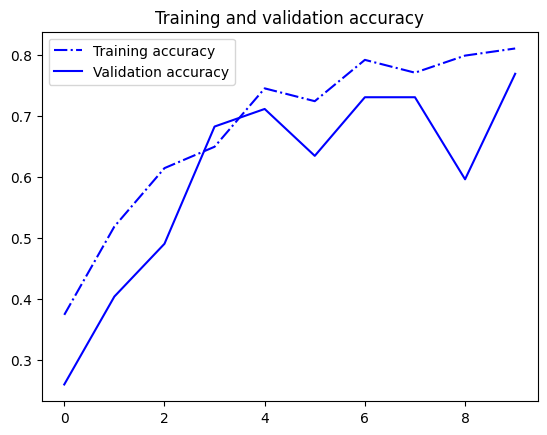

In [ ]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-.', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

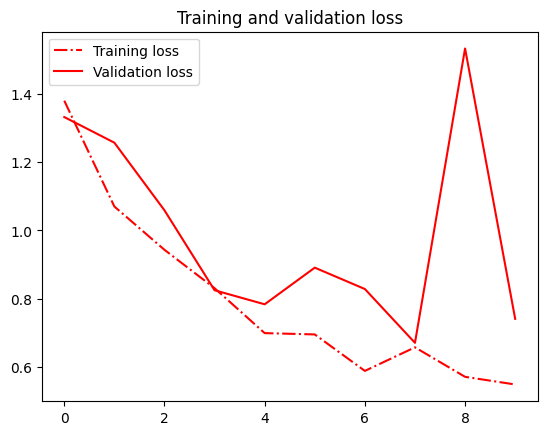

In [ ]:
plt.plot(epochs, loss, 'r-.', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt. legend()
plt.show()

In [ ]:
#last epoch parameters

m_accuracy = accuracy[9]
m_val_accuracy = val_accuracy[9]
m_loss = loss[9]
m_val_loss = val_loss[9]

In [ ]:
model_dict['ResNet50'] = [m_accuracy, m_val_accuracy, m_loss, m_val_loss]
model_dict

{'ResNet50': [0.8107476830482483,
  0.7692307829856873,
  0.5483231544494629,
  0.7407128214836121]}

6.2 ResNet101

In [ ]:
basemodel = ResNet101(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

171446536/171446536 [==============================] - 2s 0us/step


In [ ]:
#check the list of layers

basemodel.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [ ]:
for layer in basemodel.layers[:-10]:
	layer.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 4,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_generator.n // 4,
    callbacks =[checkpointer, earlystopping]
)

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 1.2484 - accuracy: 0.4509
Epoch 1: val_loss did not improve from 0.67041
107/107 [==============================] - 317s 3s/step - loss: 1.2484 - accuracy: 0.4509 - val_loss: 1.3325 - val_accuracy: 0.2692
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.9555 - accuracy: 0.5818
Epoch 2: val_loss did not improve from 0.67041
107/107 [==============================] - 297s 3s/step - loss: 0.9555 - accuracy: 0.5818 - val_loss: 2.1513 - val_accuracy: 0.2596
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.8541 - accuracy: 0.6495
Epoch 3: val_loss did not improve from 0.67041
107/107 [==============================] - 301s 3s/step - loss: 0.8541 - accuracy: 0.6495 - val_loss: 1.6769 - val_accuracy: 0.4423
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.7103
Epoch 4: val_loss did not improve from 0.67041
107/107 [=======================

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

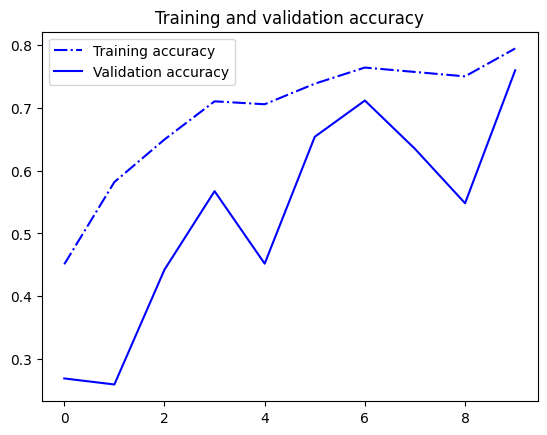

In [ ]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-.', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

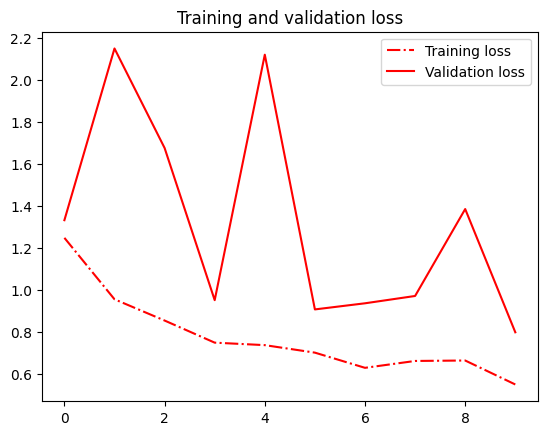

In [ ]:
plt.plot(epochs, loss, 'r-.', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt. legend()
plt.show()

In [ ]:
#last epoch parameters

m_accuracy = accuracy[9]
m_val_accuracy = val_accuracy[9]
m_loss = loss[9]
m_val_loss = val_loss[9]

In [ ]:
model_dict['ResNet101'] = [m_accuracy, m_val_accuracy, m_loss, m_val_loss]
model_dict

{'ResNet50': [0.8107476830482483,
  0.7692307829856873,
  0.5483231544494629,
  0.7407128214836121],
 'ResNet101': [0.7943925261497498,
  0.7596153616905212,
  0.5492565631866455,
  0.7980765104293823]}

6.3 VGG16

In [ ]:
basemodel = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#check the list of layers

basemodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
for layer in basemodel.layers[:-8]:
	layer.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 4,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_generator.n // 4,
    callbacks =[checkpointer, earlystopping]
)

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 1.3832 - accuracy: 0.3061
Epoch 1: val_loss did not improve from 0.67041
107/107 [==============================] - 813s 8s/step - loss: 1.3832 - accuracy: 0.3061 - val_loss: 1.3792 - val_accuracy: 0.4231
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.6238
Epoch 2: val_loss did not improve from 0.67041
107/107 [==============================] - 801s 7s/step - loss: 0.9237 - accuracy: 0.6238 - val_loss: 0.7095 - val_accuracy: 0.7212
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.7780
Epoch 3: val_loss did not improve from 0.67041
107/107 [==============================] - 850s 8s/step - loss: 0.6954 - accuracy: 0.7780 - val_loss: 0.9620 - val_accuracy: 0.6538
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.8178
Epoch 4: val_loss improved from 0.67041 to 0.53501, saving model to /content/dr

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

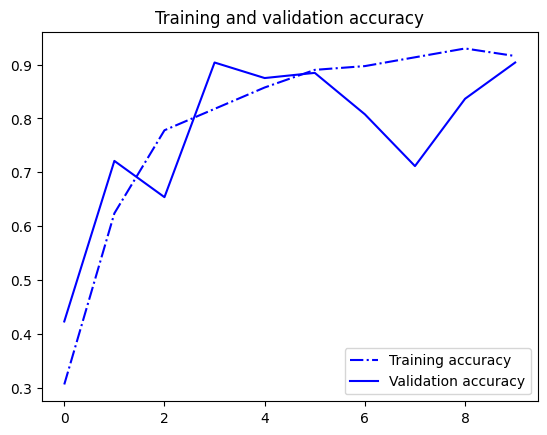

In [ ]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-.', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

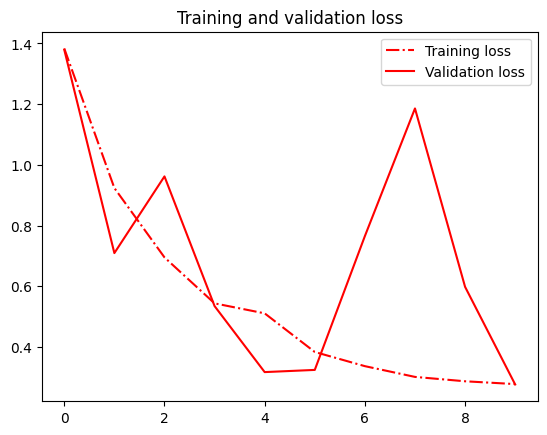

In [ ]:
plt.plot(epochs, loss, 'r-.', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt. legend()
plt.show()

In [ ]:
#last epoch parameters

m_accuracy = accuracy[9]
m_val_accuracy = val_accuracy[9]
m_loss = loss[9]
m_val_loss = val_loss[9]

In [ ]:
model_dict['VGG16'] = [m_accuracy, m_val_accuracy, m_loss, m_val_loss]
model_dict

{'ResNet50': [0.8107476830482483,
  0.7692307829856873,
  0.5483231544494629,
  0.7407128214836121],
 'ResNet101': [0.7943925261497498,
  0.7596153616905212,
  0.5492565631866455,
  0.7980765104293823],
 'VGG16': [0.9158878326416016,
  0.9038461446762085,
  0.2781324088573456,
  0.2768537402153015]}

6.4 DenseNet121

In [ ]:
basemodel = DenseNet121(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
#check the list of layers

basemodel.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']

In [ ]:
for layer in basemodel.layers[:-10]:
	layer.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 4,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_generator.n // 4,
    callbacks =[checkpointer, earlystopping]
)

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 1.1590 - accuracy: 0.5304
Epoch 1: val_loss did not improve from 0.27685
107/107 [==============================] - 140s 1s/step - loss: 1.1590 - accuracy: 0.5304 - val_loss: 0.6813 - val_accuracy: 0.7692
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.7056
Epoch 2: val_loss did not improve from 0.27685
107/107 [==============================] - 137s 1s/step - loss: 0.7372 - accuracy: 0.7056 - val_loss: 0.5123 - val_accuracy: 0.7981
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.7897
Epoch 3: val_loss did not improve from 0.27685
107/107 [==============================] - 140s 1s/step - loss: 0.5737 - accuracy: 0.7897 - val_loss: 0.4054 - val_accuracy: 0.8654
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.8318
Epoch 4: val_loss did not improve from 0.27685
107/107 [=======================

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

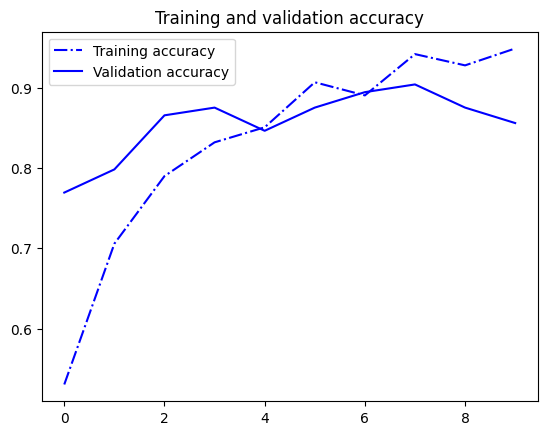

In [ ]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-.', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

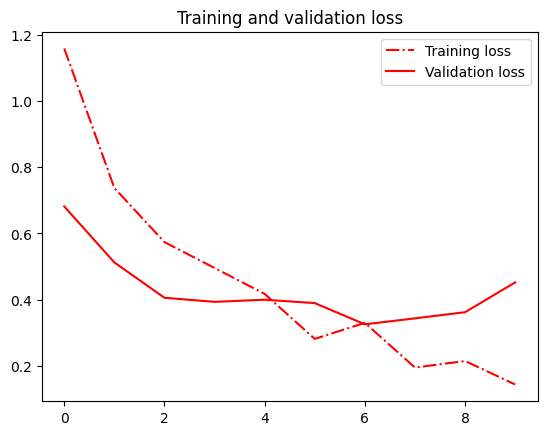

In [ ]:
plt.plot(epochs, loss, 'r-.', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt. legend()
plt.show()

In [ ]:
#last epoch parameters

m_accuracy = accuracy[9]
m_val_accuracy = val_accuracy[9]
m_loss = loss[9]
m_val_loss = val_loss[9]

In [ ]:
model_dict['DenseNet121'] = [m_accuracy, m_val_accuracy, m_loss, m_val_loss]
model_dict

{'ResNet50': [0.8107476830482483,
  0.7692307829856873,
  0.5483231544494629,
  0.7407128214836121],
 'ResNet101': [0.7943925261497498,
  0.7596153616905212,
  0.5492565631866455,
  0.7980765104293823],
 'VGG16': [0.9158878326416016,
  0.9038461446762085,
  0.2781324088573456,
  0.2768537402153015],
 'DenseNet121': [0.9485981464385986,
  0.8557692170143127,
  0.1433337926864624,
  0.45197466015815735]}

<h3> 7. Results </h3>

In [ ]:
results = pd.DataFrame.from_dict(model_dict, orient='index').reset_index()
results

,index,0,1,2,3
0,ResNet50,0.810748,0.769231,0.548323,0.740713
1,ResNet101,0.794393,0.759615,0.549257,0.798077
2,VGG16,0.915888,0.903846,0.278132,0.276854
3,DenseNet121,0.948598,0.855769,0.143334,0.451975


In [ ]:
results.columns = ['model','accuracy','val_accuracy','loss','val_loss']
results

,model,accuracy,val_accuracy,loss,val_loss
0,ResNet50,0.810748,0.769231,0.548323,0.740713
1,ResNet101,0.794393,0.759615,0.549257,0.798077
2,VGG16,0.915888,0.903846,0.278132,0.276854
3,DenseNet121,0.948598,0.855769,0.143334,0.451975


In [ ]:
results.sort_values(by = 'val_accuracy', ascending = False)

,model,accuracy,val_accuracy,loss,val_loss
2,VGG16,0.915888,0.903846,0.278132,0.276854
3,DenseNet121,0.948598,0.855769,0.143334,0.451975
0,ResNet50,0.810748,0.769231,0.548323,0.740713
1,ResNet101,0.794393,0.759615,0.549257,0.798077


(0.6, 1.02)

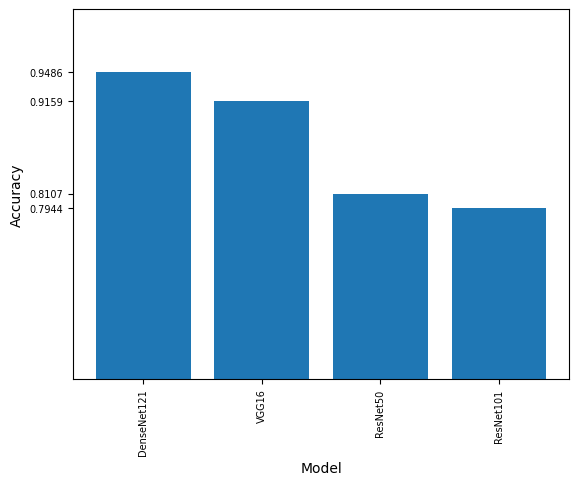

In [ ]:
results_plot = results.sort_values('accuracy',ascending=False)
plt.bar(results_plot['model'], results_plot['accuracy'])
plt.xticks(results_plot['model'],rotation = 90, fontsize = 7)
plt.yticks(results_plot['accuracy'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.60, 1.02)

(0.6, 1.02)

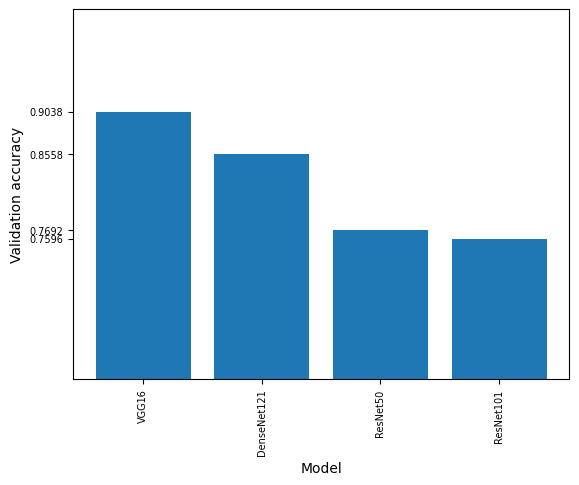

In [ ]:
results_plot = results.sort_values('val_accuracy',ascending=False)
plt.bar(results_plot['model'], results_plot['val_accuracy'])
plt.xticks(results_plot['model'],rotation = 90, fontsize = 7)
plt.yticks(results_plot['val_accuracy'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('Validation accuracy')
plt.ylim(0.60, 1.02)